In [2]:
import sionna.rt
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import math
import drjit as dr

from sionna.rt import load_scene, PlanarArray, Transmitter, Receiver, Camera,\
                      PathSolver, RadioMapSolver, subcarrier_frequencies

using_preview = True




In [3]:
current_scene = load_scene(sionna.rt.scene.florence)
current_scene.frequency = 3e9


#current_scene.tx_array = PlanarArray(num_rows=1,
#                             num_cols=1,
#                             vertical_spacing=0.5,
#                             horizontal_spacing=0.5,
#                             pattern="tr38901",
#                             polarization="V")

# Configure antenna array for all transmitters
current_scene.tx_array = PlanarArray(num_rows=1,
                             num_cols=1, 
                             vertical_spacing=0.5,
                             horizontal_spacing=0.5,
                             pattern="tr38901",
                             polarization="V")

# Configure antenna array for all receivers
#current_scene.rx_array = PlanarArray(num_rows=1,
#                             num_cols=1,
#                             vertical_spacing=0.5,
#                             horizontal_spacing=0.5,
#                             pattern="dipole",
#                             polarization="cross")

# Create transmitter
txs = []
for x in range(3):
    for y in range(3):
        tx = Transmitter(name=f"tx{x*3+y}", position=[250*(x-1),250*(y-1),50], display_radius=10, power_dbm=80)
        txs.append(tx)
        current_scene.add(tx)

# Add transmitter instance to scene
for tx in txs:
    current_scene.add(tx)



# Create a receiver
#rx = Receiver(name="rx",
#              position=[0,5,10],
#              display_radius=10)

# Add receiver instance to scene#
#current_scene.add(rx)

#tx.look_at(rx) # Transmitter points towards receiver

#cam = Camera(position=[0,0,500], look_at=[0,0,0])
#current_scene.render(camera=cam);


if(using_preview):
    current_scene.preview();



In [4]:
rm_solver = RadioMapSolver()
rm = rm_solver(current_scene,
               max_depth=30,           # Maximum number of ray scene interactions
               samples_per_tx=10**7 , # If you increase: less noise, but more memory required
               cell_size=(5, 5),      # Resolution of the radio map
               center=[0, 0, 5],      # Center of the radio map
               size=[1000, 1000],       # Total size of the radio map
               orientation=[0, 0, 0]) # Orientation of the radio map, e.g., could be also vertical


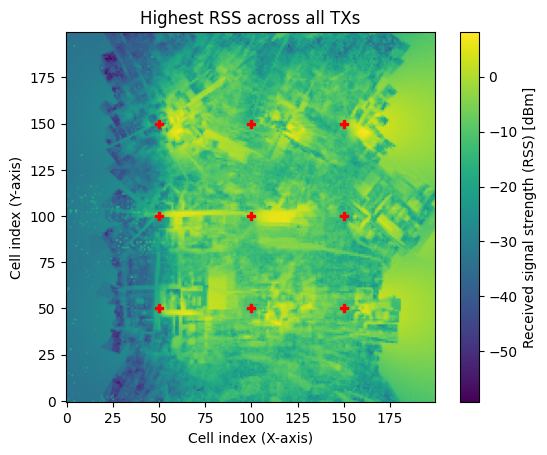

In [5]:
rm.show(metric="rss");
if(using_preview):
    current_scene.preview(radio_map=rm, rm_metric='rss');


[-58.8465, -58.51, -58.1734, .. 194 skipped .., 7.45049, 7.78703, 8.12356]


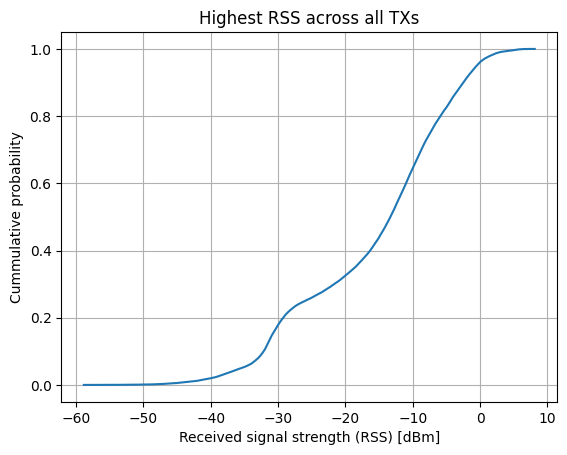

In [6]:
dr.enable_grad(rm)
cdf_values = rm.cdf(metric="rss");
print(cdf_values[1])

In [7]:
#constants
psens = 0.000001 #(dbm)
psat = 0.001 #(dbm)
a = 7000
b = 5.2


#Calculating Power Recieved
def DC_power_recieved(input_power):
    psig = 1 + np.exp(-a * psens + b)
    psig /= 1 + np.exp(-a*input_power + b)
    psig -= 1
    psig *= psat/np.exp(-a * psens + b) 

    if(psig < 0):
        psig = 0

    return psig

def power_recieved_dbm(input_power):
    power_W = math.pow(10, input_power/10)/1000
    power_W = DC_power_recieved(power_W)
    if(power_W == 0):
        return -140
    else:
        return 10 * math.log(1000 * power_W)

#vals = [-30, -20, -10, 0, 10]
#
#for x in vals:
#    print(f"power recieved by {x}dbm is {power_recieved_dbm(x)}dbm")


#from matplotlib import pyplot as plt

#plt.rcParams["figure.figsize"] = [7.50, 3.50]
#plt.rcParams["figure.autolayout"] = True

#def f(x):
#   return np.sin(x) + x + x * np.sin(x)

#x = np.linspace(0.000001, 0.000007, 100)

#plt.plot(x, DC_power_recieved(x), color='red')

#plt.show()

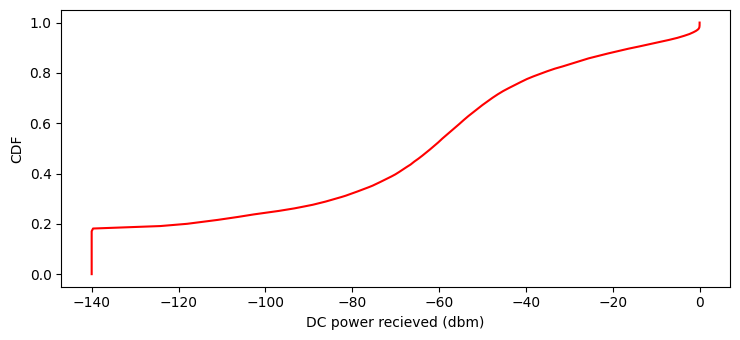

In [8]:
DC_x = []
y = []

for i in range(len(cdf_values[1])):
    #print(cdf_values[1][i], " ", power_recieved_dbm(cdf_values[1][i]))
    DC_x.append(power_recieved_dbm(cdf_values[1][i]))

from matplotlib import pyplot as plt

plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True

for val in cdf_values[2]:
    y.append(val)

plt.plot(DC_x, y, color='red')
plt.ylabel("CDF")
plt.xlabel("DC power recieved (dbm)")

plt.show()

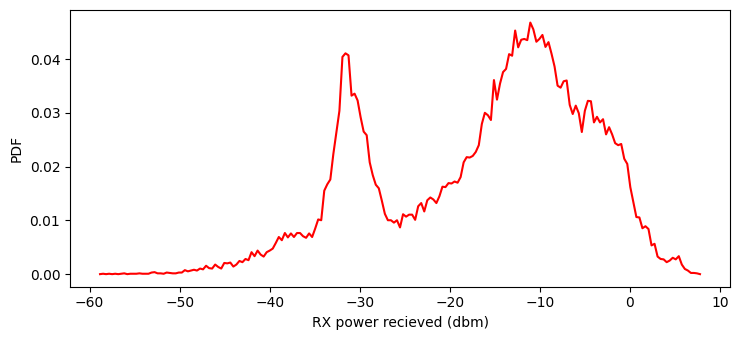

In [ ]:
#Calculating slope for PDF function from CDF function

def calculate_slope(x1, y1, x2, y2):
    return (y2 - y1)/(x2 - x1)

PDF_values = []
PDF_x_values = []

for i in range(len(cdf_values[1])-1):
    PDF_x_values.append(cdf_values[1][i])


for i in range(len(cdf_values[1]) - 1):
    slope = calculate_slope(cdf_values[1][i], cdf_values[2][i], cdf_values[1][i+1], cdf_values[2][i+1])
    PDF_values.append(slope)


plt.plot(PDF_x_values, PDF_values, color='red')
plt.ylabel("PDF")
plt.xlabel("RX power recieved (dbm)")

plt.show()


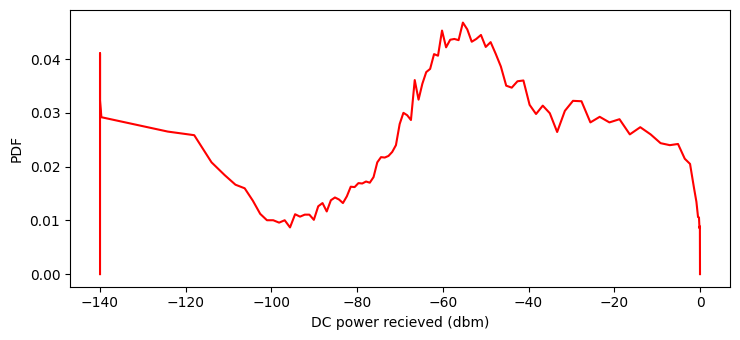

In [10]:
plt.plot(DC_x[0:199], PDF_values, color='red')
plt.ylabel("PDF")
plt.xlabel("DC power recieved (dbm)")

plt.show()

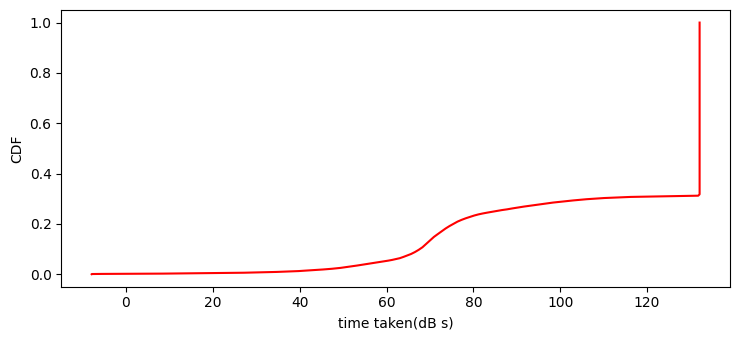

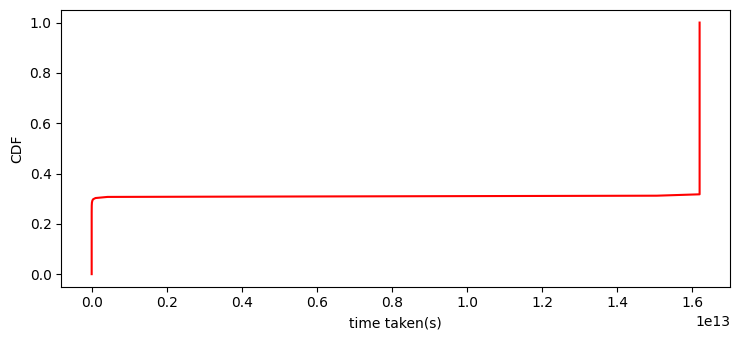

In [11]:
#Calculating time length from voltage (values from paper)
R = 0.1
C = 0.0001
VC = 1.8

total_energy = 0.5 * C * VC * VC

def calculate_time(input_power):
    #A = math.sqrt(C * VC + 4 * C * R * input_power)
    #t = math.log((A + C * VC)/(A - C * VC)) + (2 * C * VC)/(A - C * VC)
    #t *= 0.5 * R * C
    #print(f"power: {input_power}W, time : {total_energy/input_power}s")
    #return t
    return total_energy/input_power

def calculate_time_from_db(power_db):
    power_W = math.pow(10, power_db/10)/1000
    return calculate_time(power_W)

def calculate_time_in_dbs(power_db):
    time = calculate_time_from_db(power_db)
    return 10 * math.log10(time)

#x-axis for time to charge chart
time_x = []

#Create list of times taken to charge
for x in DC_x:
    time_x.append(calculate_time_in_dbs(x))

#flips CDF
y.reverse()
plt.plot(time_x, y, color='red')
plt.ylabel("CDF")
plt.xlabel("time taken(dB s)")
plt.show()

time_x = []
for x in DC_x:
    time_x.append(calculate_time_from_db(x))

plt.plot(time_x, y, color='red')
plt.ylabel("CDF")
plt.xlabel("time taken(s)")
plt.show()


In [12]:
#Calculate useful probability metrics like mean and median power absorbed, power taken

median_energy_RX = 0
median_energy_DC = 0
median_charging_time = 0
mean_energy_RX = 0
mean_energy_DC = 0
mean_charging_time = 0

#Calculates all of the above values
#Needs CDF values and PDF values
def calculate_metrics():
    global median_energy_RX, median_energy_DC, median_charging_time, mean_energy_RX, mean_energy_DC, mean_charging_time
    
    #Calculate median 
    for i in range(len(cdf_values[2])):
        if (cdf_values[2][i] > 0.5):
            median_energy_RX = cdf_values[1][i]
            break

    median_energy_DC = power_recieved_dbm(median_energy_RX)
    median_charging_time = calculate_time_from_db(median_energy_DC)
    
    
    #Calculate mean (calculate integral of x * PDF)
    area_accumulator = 0
    for i in range(len(PDF_values)-1):
        area = 0.5 * (PDF_x_values[i+1] - PDF_x_values[i]) * (PDF_values[i+1] * PDF_x_values[i+1] + PDF_values[i] * PDF_x_values[i]) 
        area_accumulator += area

    mean_energy_RX = area_accumulator

    mean_energy_DC = power_recieved_dbm(mean_energy_RX)
    mean_charging_time = calculate_time_from_db(mean_energy_DC)

    
calculate_metrics()
print(f"Mean Energy RX: {mean_energy_RX} dbm, Median Energy RX: {median_energy_RX} dbm")
print(f"Mean Energy DC: {mean_energy_DC} dbm, Median Energy DC: {median_energy_DC} dbm")
print(f"Mean Energy time: {mean_charging_time} s, Median Energy time: {median_charging_time} s")
    

Mean Energy RX: -16.204746335812846 dbm, Median Energy RX: -13.078022003173828 dbm
Mean Energy DC: -69.4605804769069 dbm, Median Energy DC: -61.13158872470548 dbm
Mean Energy time: 1430780.6636801425 s, Median Energy time: 210219.92993954517 s


In [13]:
#Sample 100 locations and give values for each of those positions
#Takes sum of all transmitter values

from random import randrange

num_transmitters = 9
for i in range(100):
    position_energy_RX = 0
    for t in range(num_transmitters):
        position_energy_RX += (rm.rss.numpy())[t][randrange(50, 150)][randrange(50, 150)]

    position_energy_dbm = 10 * math.log10(position_energy_RX) + 30
    position_energy_DC = power_recieved_dbm(position_energy_dbm)
    position_charging_time = calculate_time_from_db(position_energy_DC)
        
    print(f"Energy absorbed: {position_energy_dbm} dbm \t DC energy: {position_energy_DC} dbm \t charging time: {position_charging_time} s")

Energy absorbed: -12.073424048747576 dbm 	 DC energy: -58.30601664619279 dbm 	 charging time: 109677.28196066398 s
Energy absorbed: -12.68025422103642 dbm 	 DC energy: -60.025172632411966 dbm 	 charging time: 162941.71302398105 s
Energy absorbed: -4.806907088227163 dbm 	 DC energy: -30.44921115247942 dbm 	 charging time: 179.65368501921068 s
Energy absorbed: -9.514311403210854 dbm 	 DC energy: -50.459497468321295 dbm 	 charging time: 18007.97011964607 s
Energy absorbed: -11.342978779604415 dbm 	 DC energy: -56.17721145827247 dbm 	 charging time: 67179.4061356714 s
Energy absorbed: -7.695977379212721 dbm 	 DC energy: -43.93952692539678 dbm 	 charging time: 4012.9865771243158 s
Energy absorbed: -16.565710462678844 dbm 	 DC energy: -70.39728941695502 dbm 	 charging time: 1775186.376309237 s
Energy absorbed: -4.036968402599086 dbm 	 DC energy: -25.863370821571042 dbm 	 charging time: 62.495982025443226 s
Energy absorbed: -5.990085875682134 dbm 	 DC energy: -36.59062668455046 dbm 	 charging